In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 13

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

from sklearn.neighbors import NearestNeighbors

## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [2]:
fname,fnamey="x_12d.dat","y_12d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  L=D=",D)
x=data

N= 600   L=D= 12


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

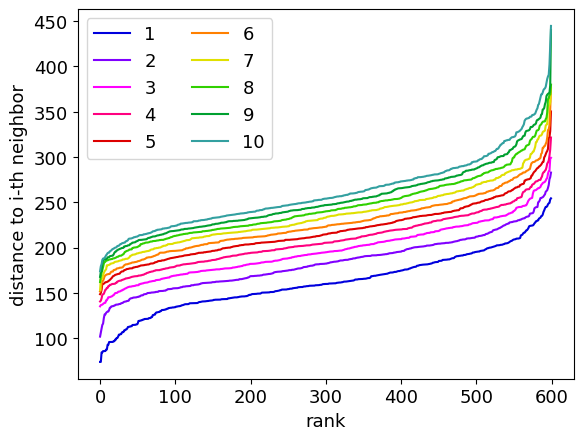

mean minimum distance between points:  162.34622464324366


In [3]:
nn = 10
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'
d, ind = nbrs.kneighbors(x) # returns indices of and distances to the neighbors of each point 
dd=d.T # riga 0 = [distanza del primo sample da neighbour 0 (sè stesso) , distanza del sample 2 da neighbour 0 (sè stesso), ..]
       # riga i = [distanza del primo sample da neighbour i, distanza del sample 2 da neighbour i]
# dd -- 11 righe, 600 colonne 

# note: dd[0] has a trivial set of zeros
listc= ["#0000DD","#8000FF","#FF00FF","#FF0080","#DD0000",
        "#FF8000","#E0E000","#30D000","#00A030","#33A0A0"]

# plot i represent distances from neighbor i 
for i in range(1,nn+1):
    plt.plot(np.sort(dd[i]),c=listc[i-1],label=str(i))
    plt.xlabel("rank")
    plt.ylabel("distance to i-th neighbor")
plt.legend(ncol=2)
plt.show()
mean_min_dist = np.mean(dd[1])
print("mean minimum distance between points: ",mean_min_dist)

## t-SNE visualization, for true labels

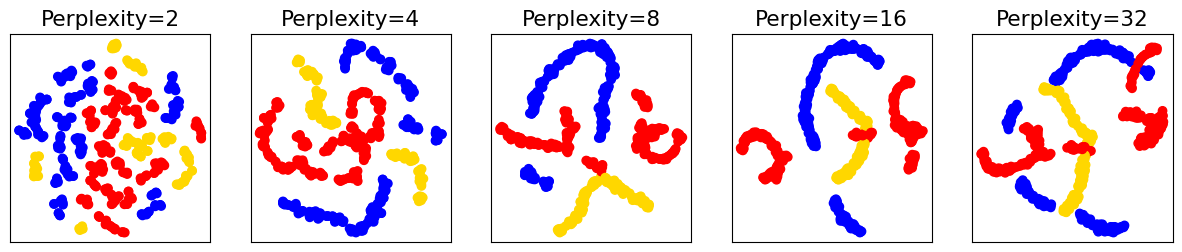

In [4]:
np.random.seed(0)
n_samples = N
n_components = 2 
perplexities = [2, 4, 8, 16, 32]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1, Np , figsize=(3*Np, 2.7))

X_all = [None]
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## Different random initial states (random_state=i)

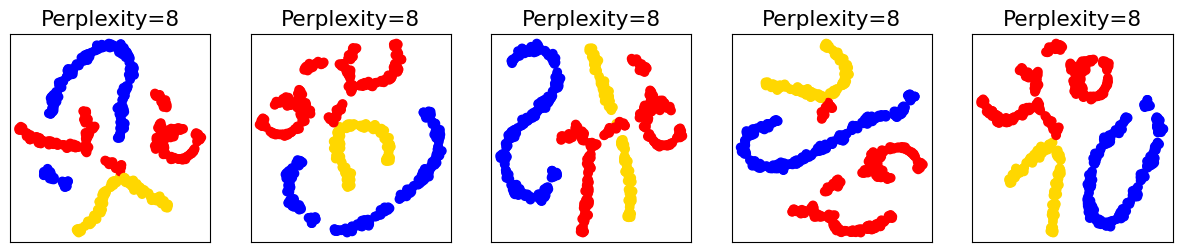

In [5]:
n_samples = N
n_components = 2 
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]

perplexity= 8

for i in range(5):
    np.random.seed(i) 
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, 
                         init='random',random_state=i, 
                         perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## DBSCAN: find labels by applying clustering

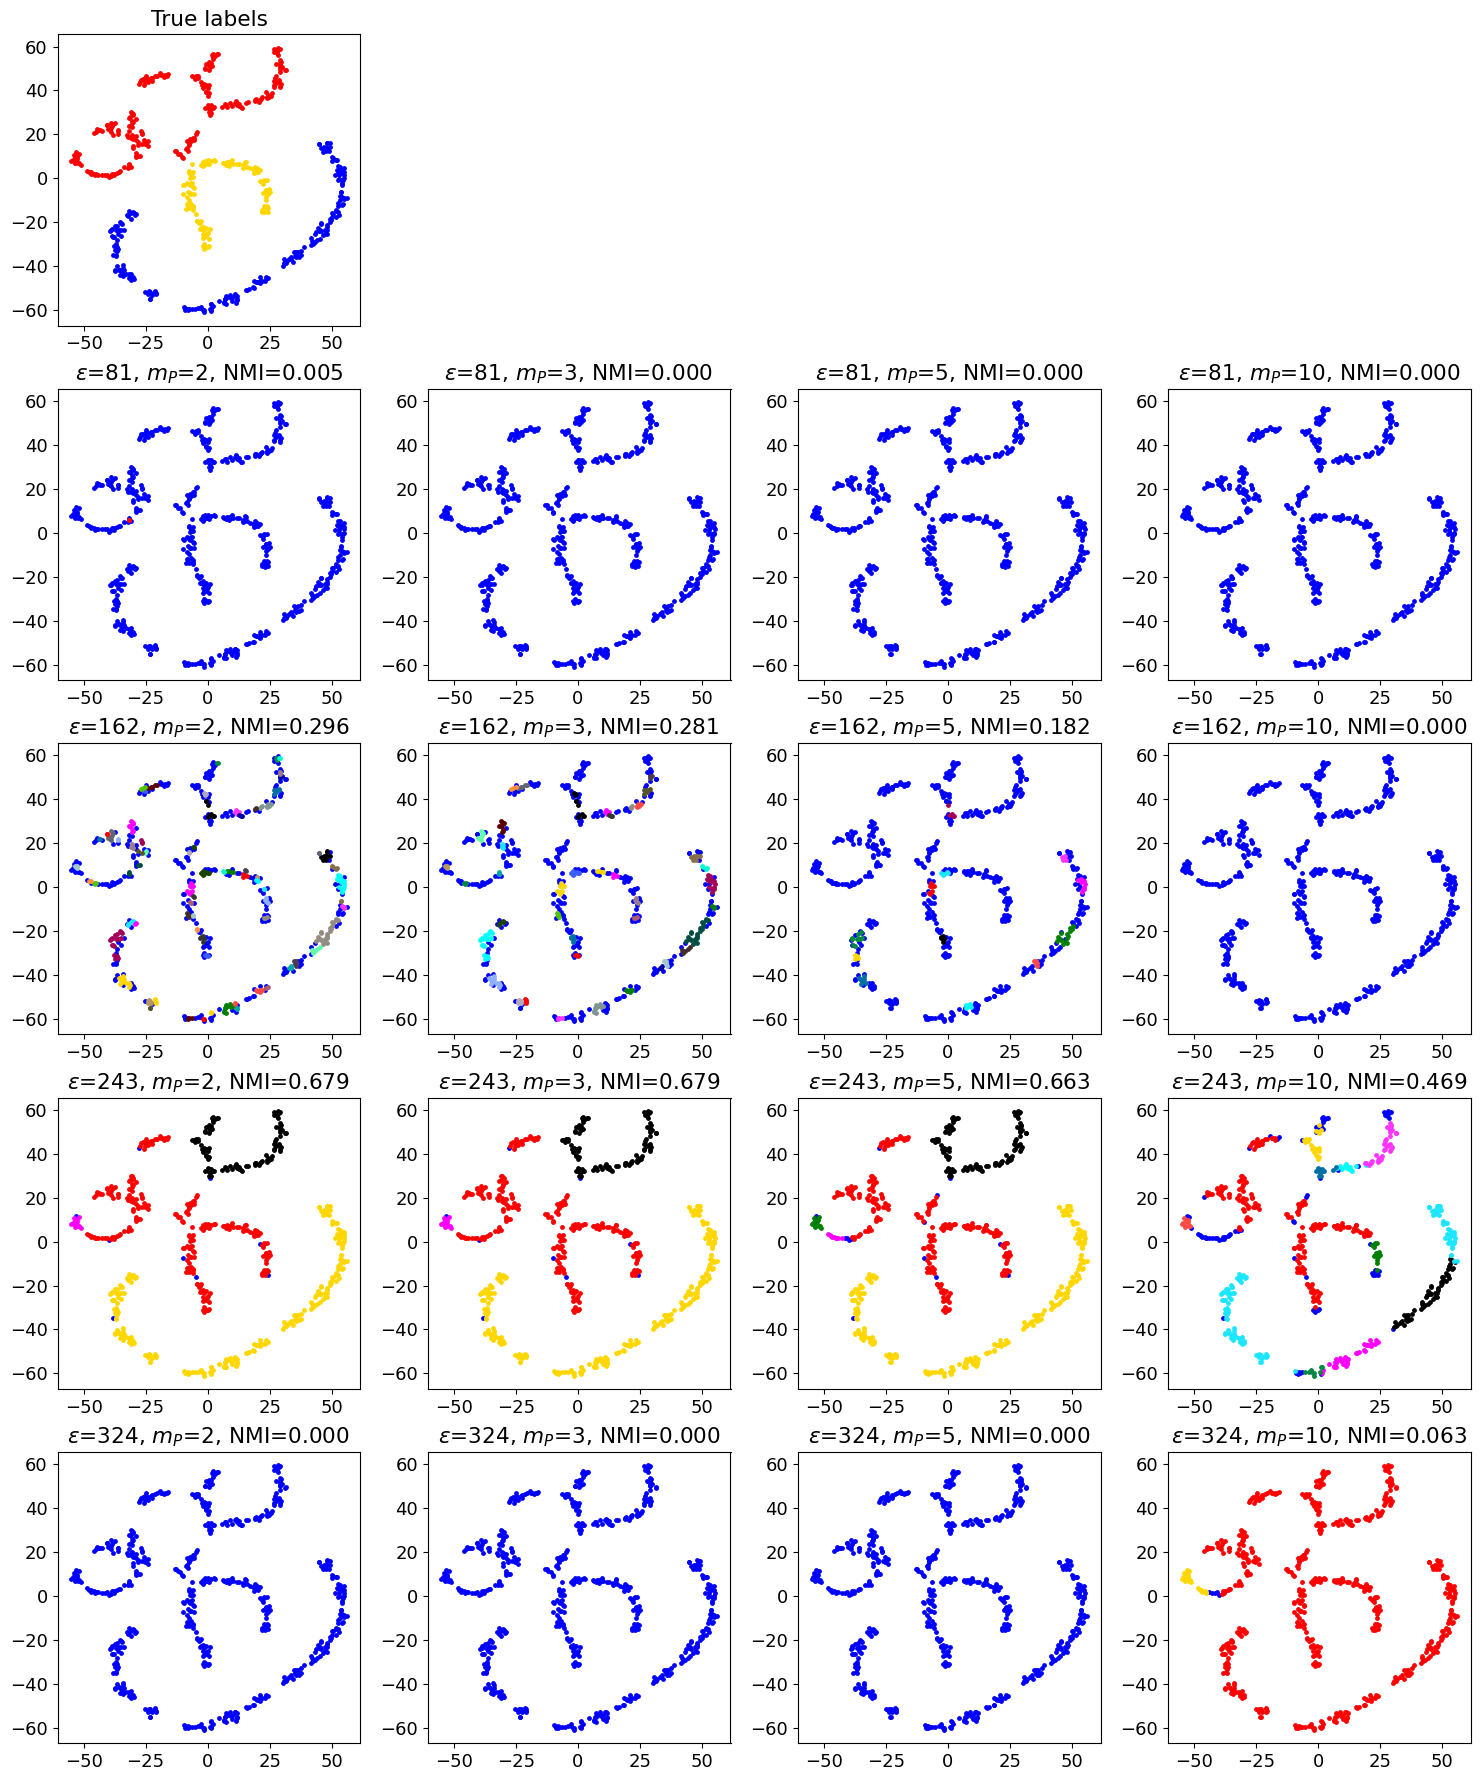

In [6]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[2] # best(?) visualization above
X = data
y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
    
eps_range = [r/2,r,1.5*r,2*r]

min_sample_range = [2,3,5,10]
DIMY=len(eps_range)
DIMX=len(min_sample_range)
fig, ax = plt.subplots(DIMY+1,DIMX,figsize=(15,18))

i,j=0,0
nmi=1
plotting_ax(X2D,y,ax[i,j])
ax[i,j].set_title('True labels')
for j in range(1,DIMX): fig.delaxes(ax[i,j])
    
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i+1,j])
        nmi=NMI(y_hat, y_true)
        ax[i+1,j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f'%(eps,min_samples,nmi))

plt.tight_layout(h_pad=0.5)
plt.show()

Cosa abbiamo fatto qui sotto:

[  0.         162.34622464 184.0420169  197.80319593 208.88332208
 218.75953886 227.35756724 236.67334031 244.88714077 252.77986017
 260.820036  ] [0, 162, 184, 197, 208, 218, 227, 236, 244, 252, 260]

 eps1[184, 197, 218, 236]
 eps2[240, 250, 255, 260]
 eps [184, 197, 218, 236, 240, 250, 255, 260]


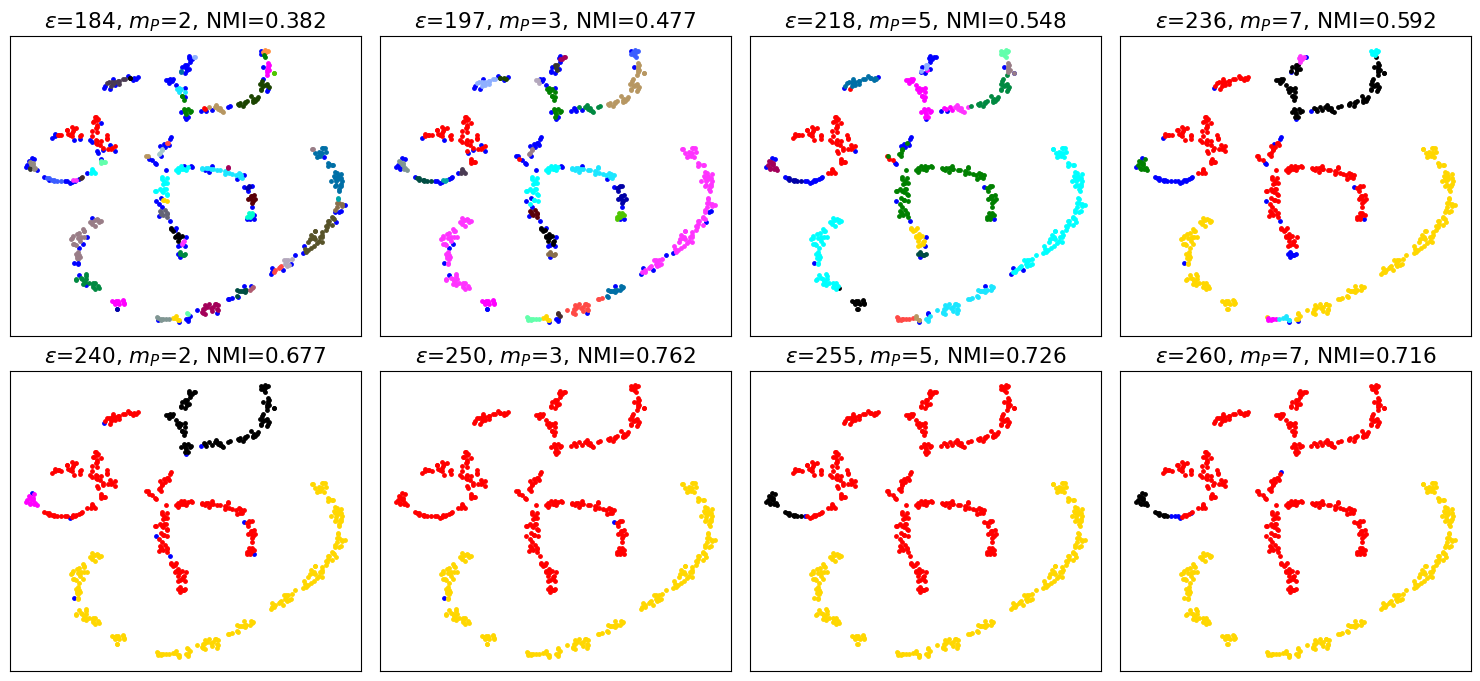

In [7]:
mean_dist = np.mean(dd, axis=1)
r = [int(d) for d in mean_dist]
print(mean_dist,r)

min_sample_range = [2, 3, 5, 7]

eps_1 = [r[i] for i in min_sample_range] # mean distance #two ways to compute eps
eps_2 = [240, 250, 255, 260] # elbow of the plot
eps = eps_1 + eps_2
print(f'\n eps1{eps_1}\n eps2{eps_2}\n eps {eps}')

fig, ax = plt.subplots(2, DIMX, figsize=(15, 7))

for i, (min_samples, eps) in enumerate(zip(min_sample_range * 2, eps)):
    model = DBSCAN(eps=eps, min_samples=min_samples,)
    model.fit(X)
    y_hat = model.labels_
    
    row = i // DIMX
    col = i % DIMX
    
    plotting_ax(X2D, y_hat, ax[row,col])
    nmi = NMI(y_hat, y_true)
    ax[row,col].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f' % (eps, min_samples, nmi))
    ax[row,col].set_xticks([])
    ax[row,col].set_yticks([])

plt.tight_layout(h_pad=0.5)
plt.show()

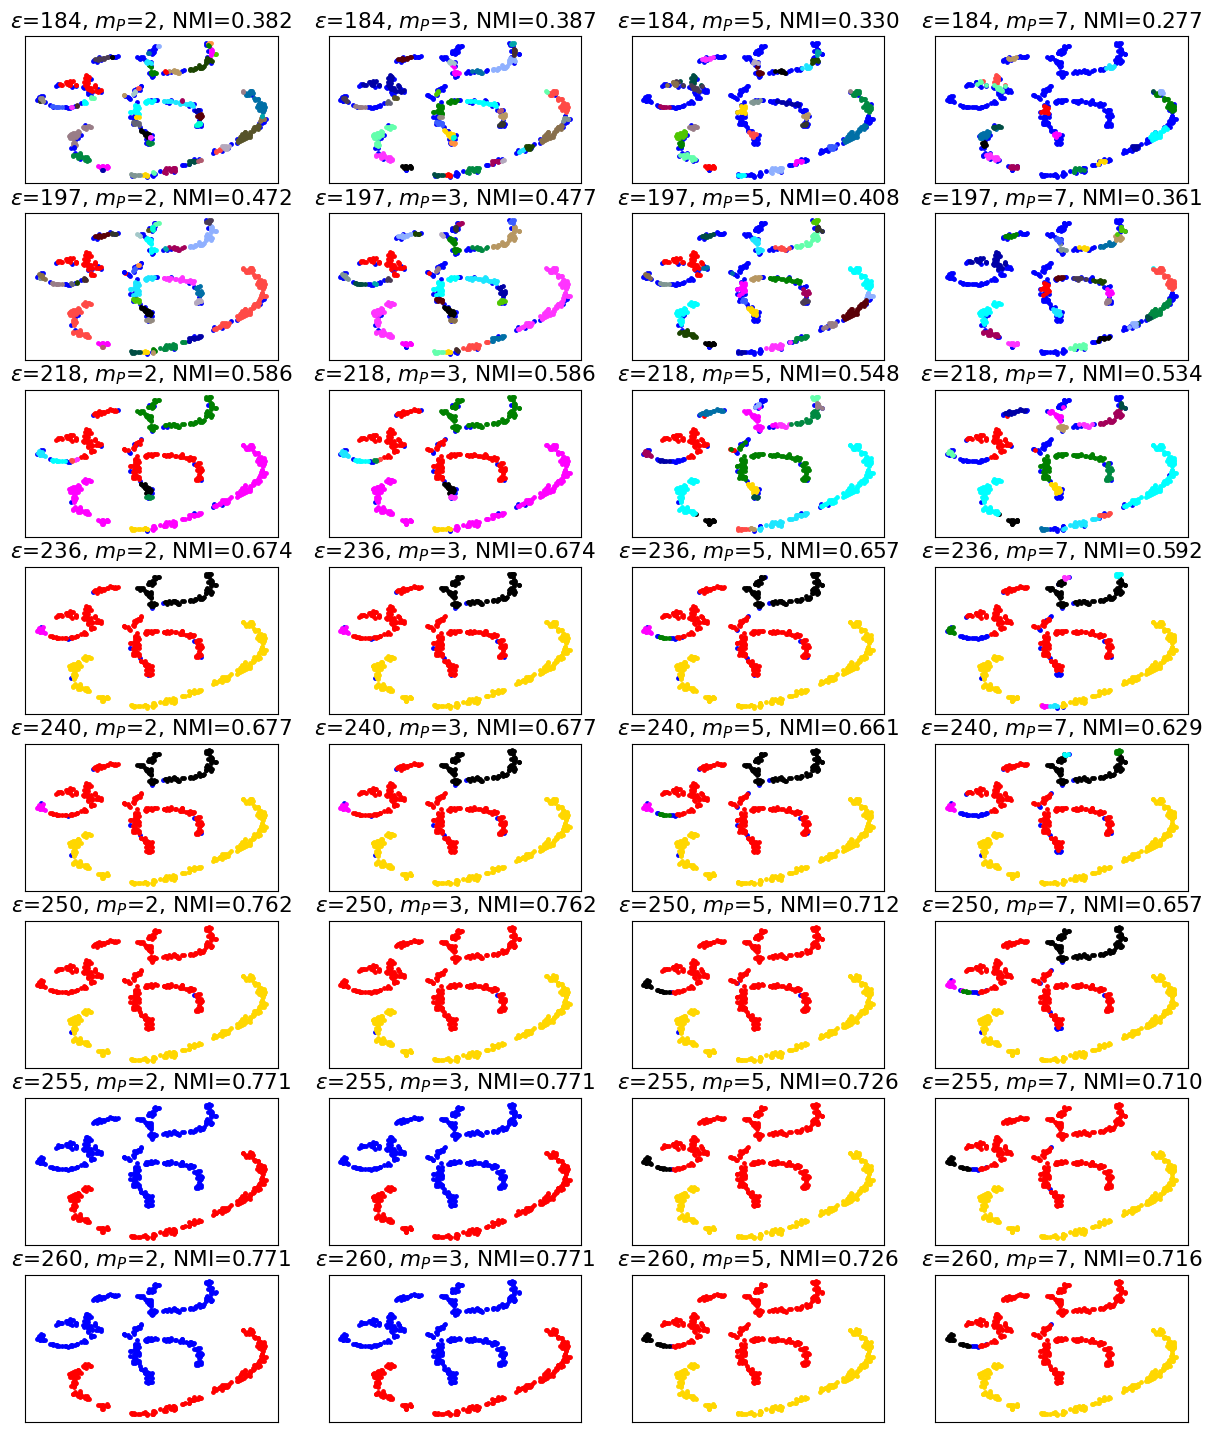

In [17]:
eps=[184, 197, 218, 236, 240, 250, 255, 260]
min_sample_range = [2, 3, 5, 7]


fig, ax = plt.subplots(len(eps), len(min_sample_range), figsize=(15, 18))
for i, e in enumerate(eps):
    for j, m in enumerate(min_sample_range):
        model = DBSCAN(eps=e, min_samples=m)
        model.fit(X)
        y_hat = model.labels_
        
        plotting_ax(X2D, y_hat, ax[i, j])
        nmi = NMI(y_hat, y_true)
        ax[i, j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f' % (e, m, nmi))
        ax[i, j].tick_params(left=False, bottom=False)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

plt.show()

Punto 1

In [18]:
#heat-map NMI

y_true = y #true labels
#function used in imshow
def z(eps,min_samples):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    model.fit(X)
    y_hat=model.labels_ #labels

    return NMI(y_hat, y_true)  

#generating the grid
EPS = np.linspace(160,300,50)
MP = np.arange(1,50,1)
m_mesh, e_mesh = np.meshgrid(MP, EPS)

y_true = y #true labels

Z = np.vectorize(z)(e_mesh, m_mesh)

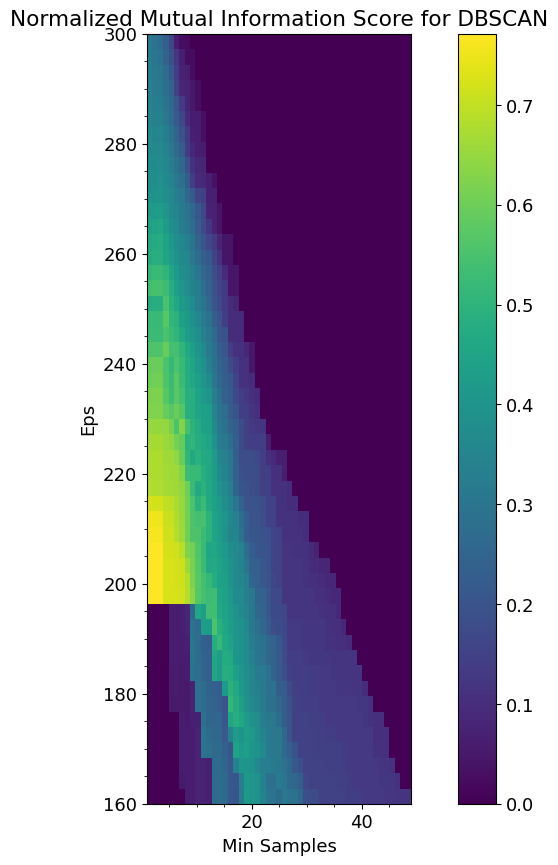

In [19]:
#plotting results
from matplotlib.ticker import AutoMinorLocator

plt.figure(figsize=(12, 10))  # Adjust the size as needed
plt.imshow(Z, vmin = Z.min(), vmax = Z.max(), 
                 extent =[ m_mesh.min(), m_mesh.max(), e_mesh.min(), e_mesh.max()])    

plt.colorbar()  # Add color bar

plt.xlabel('Min Samples')
plt.ylabel('Eps')
plt.title('Normalized Mutual Information Score for DBSCAN')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())